In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

#root_dir = '/content/gdrive/MyDrive/Data'

root_dir = '../../../Data'

Mounted at /content/gdrive


In [3]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from pandas.core.frame import DataFrame
from time import sleep


Downsampling preprocessing's dataset

In [ ]:
data_loading_dir = os.path.join(root_dir, "18 participants/AX3/Preprocessed")
experience = 1
data_saving_dir = os.path.join(root_dir, "18 participants/AX3/DownsampledDataset"+str(experience))

div = 2
portion = int(3000 / div)
sections = []
for i in range(0, 3000, portion):
  sections.append(i)
sections.append(3000)
print(sections)

def downsample(dataset):
  newDataset = pd.DataFrame()
  newDataset["Label"] = dataset["Label"]
  for i in range(div):
    newDataset["X" + str(i)] = dataset["X"].apply(lambda x : np.mean(np.array(x[sections[i]:sections[i+1]])))
    newDataset["Y" + str(i)] = dataset["Y"].apply(lambda x : np.mean(np.array(x[sections[i]:sections[i+1]])))
    newDataset["Z" + str(i)] = dataset["Z"].apply(lambda x : np.mean(np.array(x[sections[i]:sections[i+1]])))
  newDataset["Temp"] = dataset["Temp"].apply(lambda x : np.mean(np.array(x)))
  newDataset["Activity"] = dataset["Activity"]
  dataset = None
  sleep(60)
  return newDataset

[0, 1500, 3000]


In [ ]:
participants = 18

if not os.path.exists(data_saving_dir):
  os.mkdir(data_saving_dir)

for participant in range(1, participants+1):
  file_name = os.path.join(data_loading_dir, "AX3_step1_sub" + str(participant) + ".pkl")
  save_name = os.path.join(data_saving_dir, "Dataset_participant" + str(participant) + ".pkl")
  dataset = pd.read_pickle(file_name)
  newDataset = downsample(dataset)
  newDataset.to_pickle(save_name)
  dataset = None
  sleep(60)


Data transformation

In [3]:
experience = 7
data_loading_dir = os.path.join(root_dir, "18 participants/AX3/DownsampledDataset" + str(experience))
file_name = os.path.join(data_loading_dir, "Dataset_participant1.pkl")
participants = 18
orig_dataset = pd.read_pickle(file_name)

for participant in range(2, participants + 1):
  file_name = os.path.join(data_loading_dir, "Dataset_participant" + str(participant) + ".pkl")
  new_dataset = pd.read_pickle(file_name)
  orig_dataset = orig_dataset.append(new_dataset, ignore_index=True)

data_saving_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
if not os.path.exists(data_saving_dir):
  os.mkdir(data_saving_dir)

save_file = os.path.join(data_saving_dir, "Raw.pkl")
orig_dataset.to_pickle(save_file)

In [4]:
from scipy.fft import fft

def perm(orig_dataset):
  dataset = orig_dataset.drop(['Label'], axis=1)
  columns = np.array(dataset.columns)
  randIdx = random.sample(range(0, len(columns)),len(columns))
  new_columns = []
  for i in range(len(columns)):
    new_columns.append(columns[randIdx[i]])
  dataset.columns = (new_columns)
  for i in range(len(columns)):
    column = new_columns[i]
    dataset[column] = orig_dataset[column]
  return dataset

def noise(orig_dataset):
  dataset = orig_dataset.drop(['Label'], axis=1)
  stds = np.array(orig_dataset.std())
  #print(stds)
  columns = dataset.columns
  for i in range(len(columns)):
    std_val = stds[i] 
    column = columns[i]
    mean = dataset[column].mean()
    dataset['std'] = pd.DataFrame(np.random.normal(mean, std_val, (orig_dataset.shape[0],1)))
    dataset[column] = dataset[column] + dataset['std']
  dataset = dataset.drop(['std'], axis=1)
  #print(dataset.head(3))
  return dataset

def FFT(orig_dataset):
  dataset = orig_dataset.drop(['Label'], axis=1)
  columns = dataset.columns
  for i in range(len(columns)):
    column = columns[i]
    dataset[column] = fft(np.array(dataset[column]))
  return dataset

def scale(orig_dataset):
  dataset = orig_dataset.drop(['Label'], axis=1)
  columns = dataset.columns
  for column in columns:
    dataset.loc[:, column] *= 1.5
  return dataset

def negation(orig_dataset):
  dataset = orig_dataset.drop(['Label'], axis=1)
  columns = dataset.columns
  for column in columns:
    dataset.loc[:, column] *= -1
  return dataset

def negation_plus_noise(orig_dataset):
  negated_dataset = negation(orig_dataset)
  noised_dataset = noise(orig_dataset)
  dataset = orig_dataset.drop(['Label'], axis=1)
  columns = dataset.columns
  for column in columns:
    dataset[column] = negated_dataset[column] + noised_dataset[column]
  return dataset


In [5]:
experience = 7
numberOfClasses = 7
data_loading_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
load_file = os.path.join(data_loading_dir, "Raw.pkl")
orig_dataset = pd.read_pickle(load_file)

permuted_dataset = perm(orig_dataset)
noised_dataset = noise(orig_dataset)
fft_dataset = FFT(orig_dataset)
scaled_dataset = scale(orig_dataset)
negated_dataset = negation(orig_dataset)
negation_plus_noise_dataset = negation_plus_noise(orig_dataset)
raw_dataset = orig_dataset.drop(['Label'], axis=1)

def SaveFile(dataset, file_name):
  save_file = os.path.join(data_loading_dir, file_name + ".pkl")
  dataset.to_pickle(save_file)

def getLabel(label, length):
  data = {}
  for i in range(len(label)):
    data[i] = np.full(length,label[i])
  dataset = DataFrame(data)
  return dataset

def countNans(dataset):
  counts = 0
  columns = dataset.columns
  for i in range(len(columns)):
    column = columns[i]
    counts = counts + dataset[column].isnull().sum()
  return counts

def getLabelsDataset(numberOfClasses, length):
  label = np.zeros(numberOfClasses)
  label[0] = 1
  dataset = getLabel(label, length)
  for i in range(1, numberOfClasses):
    label = np.zeros(numberOfClasses)
    label[i] = 1
    new_dataset = getLabel(label, length)
    dataset = dataset.append(new_dataset, ignore_index=True)
    new_dataset = None
  return dataset

def windowDataset(dataset, window_size):
  new_dataset = []
  for i in range(0,dataset.shape[0], window_size):
    value = dataset[i]
    for j in range(i+1, i+window_size):
      value = np.append(value, dataset[j], axis=0)
    new_dataset.append(value)
  return np.array(new_dataset)

def windowLabels(dataset, window_size):
  new_labels = []
  for i in range(0, labels.shape[0], window_size):
    new_labels.append(labels[i])
  return np.array(new_labels)

def get_train_test_splits(dataset, spare_label, numberOfClasses):
  label = np.zeros(numberOfClasses)
  label[spare_label] = 1
  labels = getLabel(label, dataset.shape[0])
  dataset = np.array(dataset)
  n = dataset.shape[0]
  train_ratio = 0.9
  separate_id = int(n * train_ratio)

  x_train = dataset[:separate_id]
  y_train = labels[:separate_id]

  x_test = dataset[separate_id:]
  y_test = labels[separate_id:]
  return x_train, y_train, x_test, y_test  

SaveFile(permuted_dataset, "Permuted")
SaveFile(noised_dataset, "Noised")
SaveFile(fft_dataset, "FFT")
SaveFile(scaled_dataset, "Scaled")
SaveFile(negated_dataset, "Negated")
SaveFile(negation_plus_noise_dataset, "Negated_Plus_Noise")

#merged_dataset = None
#merged_dataset = pd.concat([merged_dataset, raw_dataset])
#merged_dataset = pd.concat([merged_dataset, permuted_dataset])
#merged_dataset = pd.concat([merged_dataset, noised_dataset])
#merged_dataset = pd.concat([merged_dataset, fft_dataset])
#merged_dataset = pd.concat([merged_dataset, scaled_dataset])
#merged_dataset = pd.concat([merged_dataset, negated_dataset])
#merged_dataset = pd.concat([merged_dataset, negation_plus_noise_dataset])
#merged_dataset = merged_dataset.reset_index()
#SaveFile(merged_dataset, "Merged")
#print(merged_dataset.shape)

labels = getLabelsDataset(numberOfClasses, permuted_dataset.shape[0])
SaveFile(labels, "Labels")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [6]:
experience = 7
numberOfClasses = 7
data_loading_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
load_file = os.path.join(data_loading_dir, "Merged.pkl")

def getBinaryLabels(dataset_size, sparse_label, numberOfClasses):
  total = dataset_size * numberOfClasses  
  labels = np.zeros((total, 2))
  print(labels.shape)
  for i in range(total):
    labels[i][1] = 1
    if int(i/dataset_size)==sparse_label:
      labels[i][1] = 0
      labels[i][0] = 1

  return labels

def get_train_test_splits_multi_task(dataset, sparse_label, numberOfClasses):
  dataset = np.array(dataset)
  n = dataset.shape[0]
  train_ratio = 0.9
  labels = getBinaryLabels(n, sparse_label, numberOfClasses)
  separate_id = int(n * train_ratio)

  x_train = dataset[:separate_id]
  x_test = dataset[separate_id:]

  y_train = labels[:separate_id]
  y_test = labels[separate_id:n]
  for i in range(1, numberOfClasses):
    y_train_piece = labels[n * i:n * i + separate_id]
    y_test_piece = labels[n * i + separate_id:n * (i+1)]
    y_train = np.append(y_train, y_train_piece, axis=0)
    y_test = np.append(y_test, y_test_piece, axis=0)

  return x_train, y_train, x_test, y_test

x_train, y_train_raw, x_test, y_test_raw = get_train_test_splits_multi_task(raw_dataset[:1000], 0, numberOfClasses)

new_x_train, y_train_permuted, new_x_test, y_test_permuted = get_train_test_splits_multi_task(permuted_dataset[:1000], 1, numberOfClasses)

x_train = np.append(x_train, new_x_train, axis=0)
x_test = np.append(x_test, new_x_test, axis=0)

new_x_train, y_train_noised, new_x_test, y_test_noised = get_train_test_splits_multi_task(noised_dataset[:1000], 2, numberOfClasses)

x_train = np.append(x_train, new_x_train, axis=0)
x_test = np.append(x_test, new_x_test, axis=0)

new_x_train, y_train_fft, new_x_test, y_test_fft = get_train_test_splits_multi_task(fft_dataset[:1000], 3, numberOfClasses)

x_train = np.append(x_train, new_x_train, axis=0)
x_test = np.append(x_test, new_x_test, axis=0)

new_x_train, y_train_scaled, new_x_test, y_test_scaled = get_train_test_splits_multi_task(scaled_dataset[:1000], 4, numberOfClasses)

x_train = np.append(x_train, new_x_train, axis=0)
x_test = np.append(x_test, new_x_test, axis=0)

new_x_train, y_train_negated, new_x_test, y_test_negated = get_train_test_splits_multi_task(negated_dataset[:1000], 5, numberOfClasses)

x_train = np.append(x_train, new_x_train, axis=0)
x_test = np.append(x_test, new_x_test, axis=0)

new_x_train, y_train_negation_plus_noise, new_x_test, y_test_negation_plus_noise = get_train_test_splits_multi_task(negation_plus_noise_dataset[:1000], 6, numberOfClasses)

x_train = np.append(x_train, new_x_train, axis=0)
x_test = np.append(x_test, new_x_test, axis=0)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1, 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1, 1))


def change_labels(y_train, y_test):
  new_y_train = []
  new_y_test = []
  n = 1000
  for i in range(y_train.shape[0]):
    new_y_train.append(np.float32(i/n))

  y_train = np.array(new_y_train)

  n = 100
  for i in range(y_test.shape[0]):
    new_y_test.append(np.float32(i/n))

  y_test = np.array(new_y_test)

  return y_train, y_test


print(x_train.shape)
print(y_train_fft.shape)
print(x_test.shape)
print(y_test_fft.shape)

(7000, 2)
(7000, 2)
(7000, 2)
(7000, 2)
(7000, 2)
(7000, 2)
(7000, 2)
(6300, 92, 1, 1)
(6300, 2)
(700, 92, 1, 1)
(700, 2)


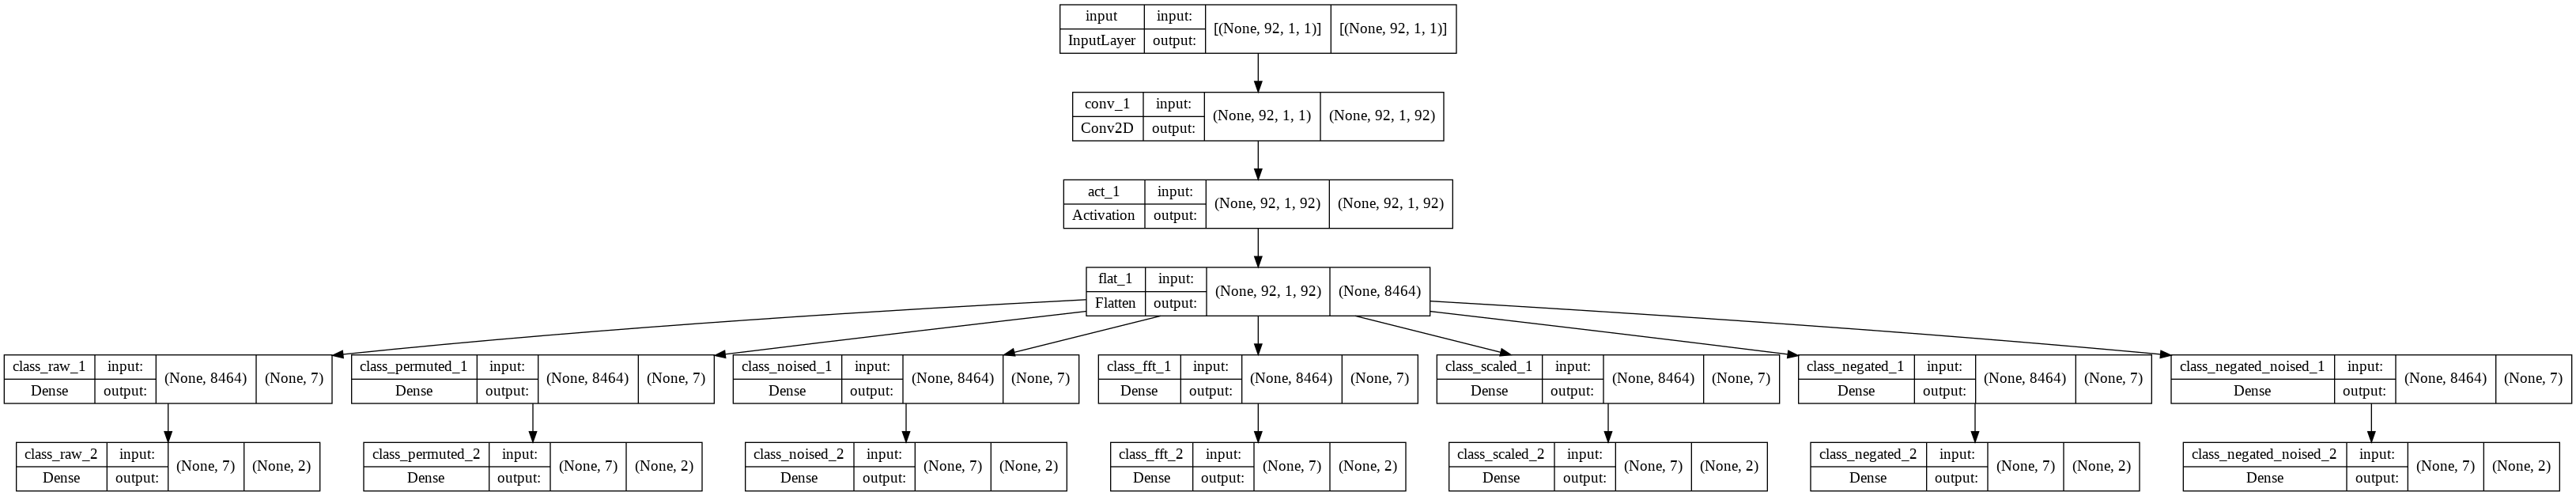

In [9]:
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Add, Dense
import keras.backend as K 

input_ = Input(shape=(x_train.shape[1],1,1), name='input')

conv_1 = Conv2D(92, 1, name='conv_1')(input_)
act_1 = Activation('relu', name='act_1')(conv_1)

flat_1 = Flatten(name='flat_1')(act_1)

class_raw_1 = Dense(7, activation='relu', name='class_raw_1')(flat_1)
class_raw_2 = Dense(2, activation='softmax', name='class_raw_2')(class_raw_1)

class_permuted_1 = Dense(7, activation='relu', name='class_permuted_1')(flat_1)
class_permuted_2 = Dense(2, activation='softmax', name='class_permuted_2')(class_permuted_1)

class_noised_1 = Dense(7, activation='relu', name='class_noised_1')(flat_1)
class_noised_2 = Dense(2, activation='softmax', name='class_noised_2')(class_noised_1)

class_fft_1 = Dense(7, activation='relu', name='class_fft_1')(flat_1)
class_fft_2 = Dense(2, activation='softmax', name='class_fft_2')(class_fft_1)

class_scaled_1 = Dense(7, activation='relu', name='class_scaled_1')(flat_1)
class_scaled_2 = Dense(2, activation='softmax', name='class_scaled_2')(class_scaled_1)

class_negated_1 = Dense(7, activation='relu', name='class_negated_1')(flat_1)
class_negated_2 = Dense(2, activation='softmax', name='class_negated_2')(class_negated_1)

class_negated_noised_1 = Dense(7, activation='relu', name='class_negated_noised_1')(flat_1)
class_negated_noised_2 = Dense(2, activation='softmax', name='class_negated_noised_2')(class_negated_noised_1)

model = tf.keras.models.Model(input_, [class_raw_2, class_permuted_2, class_noised_2, class_fft_2, class_scaled_2, class_negated_2, class_negated_noised_2])
#model.summary()

model.compile(
    loss={
        'class_raw_2': 'binary_crossentropy', 
        'class_permuted_2': 'binary_crossentropy', 
        'class_noised_2': 'binary_crossentropy', 
        'class_fft_2': 'binary_crossentropy', 
        'class_scaled_2': 'binary_crossentropy', 
        'class_negated_2': 'binary_crossentropy', 
        'class_negated_noised_2': 'binary_crossentropy'
    },
    optimizer=RMSprop(learning_rate=0.001),
    metrics=['accuracy'],
#    run_eagerly=True
)

from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)


In [76]:
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Add, Dense
import keras.backend as K 

def loss(margin=0.1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """
        print(y_pred)
        print(y_true)

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
        val = tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )
        print(val)
        print("   ")

        return val

    return contrastive_loss


input_ = Input(shape=(x_train.shape[1],1,1), name='input')

conv_1 = Conv2D(92, 1, name='conv_1')(input_)
act_1 = Activation('relu', name='act_1')(conv_1)

flat_1 = Flatten(name='flat_1')(act_1)

class_raw_1 = Dense(7, activation='relu', name='class_raw_1')(flat_1)
class_raw_2 = Dense(2, activation='softmax', name='class_raw_2')(class_raw_1)

class_permuted_1 = Dense(7, activation='relu', name='class_permuted_1')(flat_1)
class_permuted_2 = Dense(2, activation='softmax', name='class_permuted_2')(class_permuted_1)

class_noised_1 = Dense(7, activation='relu', name='class_noised_1')(flat_1)
class_noised_2 = Dense(2, activation='softmax', name='class_noised_2')(class_noised_1)

class_fft_1 = Dense(7, activation='relu', name='class_fft_1')(flat_1)
class_fft_2 = Dense(2, activation='softmax', name='class_fft_2')(class_fft_1)

class_scaled_1 = Dense(7, activation='relu', name='class_scaled_1')(flat_1)
class_scaled_2 = Dense(2, activation='softmax', name='class_scaled_2')(class_scaled_1)

class_negated_1 = Dense(7, activation='relu', name='class_negated_1')(flat_1)
class_negated_2 = Dense(2, activation='softmax', name='class_negated_2')(class_negated_1)

class_negated_noised_1 = Dense(7, activation='relu', name='class_negated_noised_1')(flat_1)
class_negated_noised_2 = Dense(2, activation='softmax', name='class_negated_noised_2')(class_negated_noised_1)

model = tf.keras.models.Model(input_, [class_raw_2, class_permuted_2, class_noised_2, class_fft_2, class_scaled_2, class_negated_2, class_negated_noised_2])
#model.summary()

model.compile(
    loss={
        'class_raw_2': 'binary_crossentropy', 
        'class_permuted_2': 'binary_crossentropy', 
        'class_noised_2': 'binary_crossentropy', 
        'class_fft_2': 'binary_crossentropy', 
        'class_scaled_2': 'binary_crossentropy', 
        'class_negated_2': 'binary_crossentropy', 
        'class_negated_noised_2': 'binary_crossentropy'
    },
    optimizer=RMSprop(learning_rate=0.001),
    metrics=['accuracy'],
#    run_eagerly=True
)

_ = model.fit(x_train, [y_train_raw, y_train_permuted, y_train_noised, y_train_fft, y_train_scaled, y_train_negated, y_train_negation_plus_noise], 
              validation_data=(x_test, [y_test_raw, y_test_permuted, y_test_noised, y_test_fft, y_test_scaled, y_test_negated, y_test_negation_plus_noise]), 
              epochs=15, batch_size=1)

#model.summary()
#from keras.utils.vis_utils import plot_model
#plot_model(model, show_shapes=True, show_layer_names=True)


Epoch 1/15
6300/6300 [==============================] - 82s 6ms/step - loss: 68.4138 - class_raw_2_loss: 6.0669 - class_permuted_2_loss: 4.4124 - class_noised_2_loss: 2.3385 - class_fft_2_loss: 47.3342 - class_scaled_2_loss: 5.8510 - class_negated_2_loss: 2.1039 - class_negated_noised_2_loss: 0.3069 - class_raw_2_accuracy: 0.8557 - class_permuted_2_accuracy: 0.9971 - class_noised_2_accuracy: 0.8567 - class_fft_2_accuracy: 0.9481 - class_scaled_2_accuracy: 0.8559 - class_negated_2_accuracy: 0.9810 - class_negated_noised_2_accuracy: 0.8773 - val_loss: 2.3426 - val_class_raw_2_loss: 0.4103 - val_class_permuted_2_loss: 0.0198 - val_class_noised_2_loss: 0.2892 - val_class_fft_2_loss: 0.7177 - val_class_scaled_2_loss: 0.4044 - val_class_negated_2_loss: 0.0410 - val_class_negated_noised_2_loss: 0.4602 - val_class_raw_2_accuracy: 0.8571 - val_class_permuted_2_accuracy: 1.0000 - val_class_noised_2_accuracy: 0.8571 - val_class_fft_2_accuracy: 0.9986 - val_class_scaled_2_accuracy: 0.8571 - val_cl

In [39]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
import keras.backend as K 
import tensorflow_addons as tfa


def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """          
        print(y_pred.numpy())
        print(y_true.numpy())
        print(" ")
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


sgd = SGD(learning_rate=0.001)
rms = RMSprop(learning_rate=0.001)
adam = Adam(learning_rate=0.001, epsilon=0.1)
model.compile(optimizer=rms,
                loss=tfa.losses.contrastive_loss,
                metrics=['accuracy'], run_eagerly=True)

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=2)

test_labels = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)
Labels = ['Raw','Permuted', 'Gaussian noised', 'FFT', 'Scaled', 'Negated', 'Negation + Noise']

printConfusionMatrix(test_labels, y_pred, Labels, show=True)

def plot_graph(x, y, z, x_label, y_label, legends, figsize=(7,7)):
  plt.plot(z, x, 'r--')
  plt.plot(z, y, 'b-')
  plt.legend(legends)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.figure(figsize=figsize)
  plt.show()

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Get training and test loss histories
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

plot_graph(training_loss, test_loss, epoch_count, 'Epoch', 'Loss', ['Training Loss', 'Test Loss'])
plot_graph(accuracy, val_accuracy, epoch_count, 'Epoch', 'Accuracy', ['Accuracy', 'Test Accuracy'])

ModuleNotFoundError: ignored

[[49667     0     0     8    35     0  1828]
 [    1 51537     0     0     0     0     0]
 [    0     0 51499     0    35     4     0]
 [  171     0     2 51155    65    50    95]
 [    1     0     3    34 51499     0     1]
 [    0     0    15   282     0 51241     0]
 [  249     0     0     0    65     0 51224]]
Precision for Raw is 0.96
Recall for Raw is 0.96
F1 Score for Raw is 0.96
Precision for Permuted is 1.0
Recall for Permuted is 1.0
F1 Score for Permuted is 1.0
Precision for Gaussian noised is 1.0
Recall for Gaussian noised is 1.0
F1 Score for Gaussian noised is 1.0
Precision for FFT is 0.99
Recall for FFT is 0.99
F1 Score for FFT is 0.99
Precision for Scaled is 1.0
Recall for Scaled is 1.0
F1 Score for Scaled is 1.0
Precision for Negated is 0.99
Recall for Negated is 0.99
F1 Score for Negated is 0.99
Precision for Negation + Noise is 0.99
Recall for Negation + Noise is 0.99
F1 Score for Negation + Noise is 0.99
Accuracy is 0.99


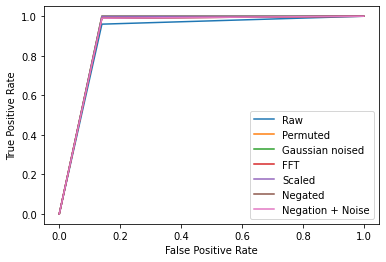

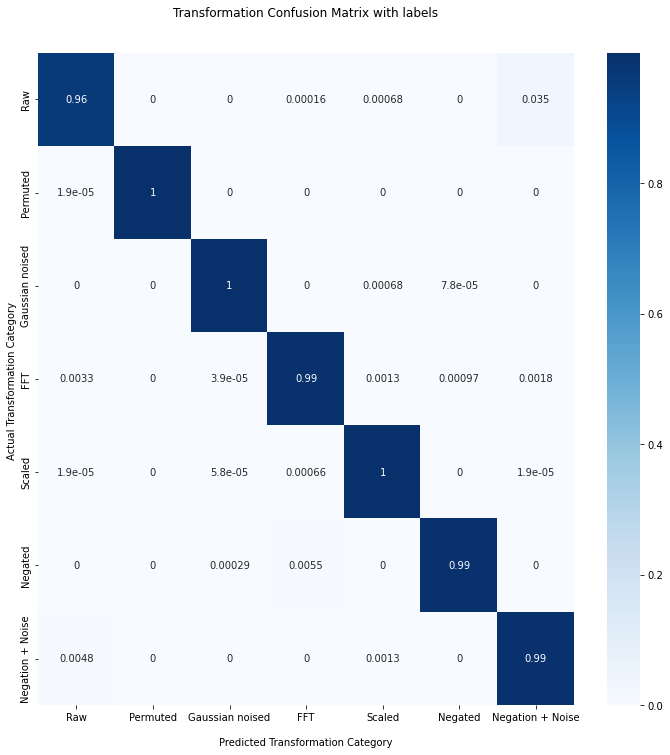

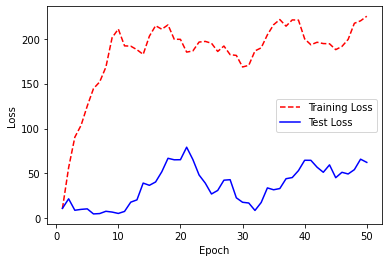

<Figure size 504x504 with 0 Axes>

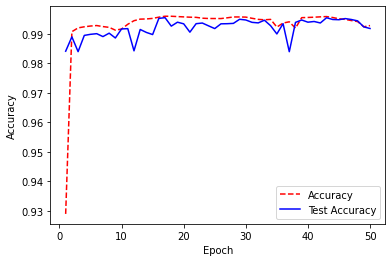

<Figure size 504x504 with 0 Axes>

In [11]:
test_labels = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)
Labels = ['Raw','Permuted', 'Gaussian noised', 'FFT', 'Scaled', 'Negated', 'Negation + Noise']

printConfusionMatrix(test_labels, y_pred, Labels, show=True)

def plot_graph(x, y, z, x_label, y_label, legends, figsize=(7,7)):
  plt.plot(z, x, 'r--')
  plt.plot(z, y, 'b-')
  plt.legend(legends)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.figure(figsize=figsize)
  plt.show()

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Get training and test loss histories
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

plot_graph(training_loss, test_loss, epoch_count, 'Epoch', 'Loss', ['Training Loss', 'Test Loss'])
plot_graph(accuracy, val_accuracy, epoch_count, 'Epoch', 'Accuracy', ['Accuracy', 'Test Accuracy'])

Extraxting the last hidden layer

In [12]:
from keras import backend as K
data_loading_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
save_file = os.path.join(data_loading_dir, "Features.pkl")

def reshapeDataset(orig_dataset):
  dataset = np.array(orig_dataset)
  dataset = dataset.reshape((dataset.shape[0], dataset.shape[1], 1, 1))
  return dataset

def InsertMatrixIntoDataframe(dataframe, array):
  for i in range(array.shape[1]):
    arr = []
    for j in range(array.shape[0]):
      arr.append(array[j][i])
    dataframe[str(i)] = np.array(arr)
  print(dataframe.head(1))
  return dataframe

# with a Sequential model
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].output])

dataset = reshapeDataset(raw_dataset)
layer_output = get_3rd_layer_output([dataset])[0]

dataset = reshapeDataset(permuted_dataset)
new_layer_output = get_3rd_layer_output([dataset])[0]
layer_output = np.append(layer_output, new_layer_output, axis=1)

dataset = reshapeDataset(noised_dataset)
new_layer_output = get_3rd_layer_output([dataset])[0]
layer_output = np.append(layer_output, new_layer_output, axis=1)

dataset = reshapeDataset(fft_dataset)
new_layer_output = get_3rd_layer_output([dataset])[0]
layer_output = np.append(layer_output, new_layer_output, axis=1)

dataset = reshapeDataset(scaled_dataset)
new_layer_output = get_3rd_layer_output([dataset])[0]
layer_output = np.append(layer_output, new_layer_output, axis=1)

dataset = reshapeDataset(negated_dataset)
new_layer_output = get_3rd_layer_output([dataset])[0]
layer_output = np.append(layer_output, new_layer_output, axis=1)

dataset = reshapeDataset(negation_plus_noise_dataset)
new_layer_output = get_3rd_layer_output([dataset])[0]
layer_output = np.append(layer_output, new_layer_output, axis=1)

merged_features = DataFrame({'Label': orig_dataset['Label']})

merged_features = InsertMatrixIntoDataframe(merged_features, layer_output)

print(merged_features.shape)
merged_features.to_pickle(save_file)

                 Label    0         1    2           3    4    5    6    7  \
0  2020-02-03 07:36:00  0.0  49.95396  0.0  289.955383  0.0  0.0  0.0  0.0   

             8  ...          39   40   41         42          43   44  \
0  3405.634033  ...  705.131958  0.0  0.0  366.19162  107.296326  0.0   

           45   46   47         48  
0  555.824951  0.0  0.0  14.997156  

[1 rows x 50 columns]
(515380, 50)


Result helper methods

In [5]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
from sklearn import metrics

def printConfusionMatrix(test_labels, y_pred, Labels, show=True):
  cf_matrix = confusion_matrix(test_labels, y_pred)
  #cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

  print(cf_matrix)

  precisions = []
  recalls = []
  FPRs = []
  n = len(test_labels)

  total_vals = 0
  tps = 0
  for i in range(cf_matrix.shape[0]):
    sum_vals = cf_matrix[i].sum()
    sum_cols = cf_matrix[:][i].sum()

    total_vals += sum_vals
    tps += cf_matrix[i][i]
    recall = round(cf_matrix[i][i]/sum_vals, 2)
    recalls.append(recall)
    precision = round(cf_matrix[i][i]/sum_cols, 2)
    precisions.append(precision)
    f1_score = round(2 * precision * recall / (recall + precision), 2)

    # ROC
    TN = n - sum_vals - sum_cols + cf_matrix[i][i]
    FP = sum_cols = cf_matrix[i][i]
    FPR = round(FP / (FP + TN), 2)
    FPRs.append(FPR)
    if show:
      print("Precision for " + Labels[i] + " is " + str(precision))
      print("Recall for " + Labels[i] + " is " + str(recall))
      print("F1 Score for " + Labels[i] + " is " + str(f1_score))

      plt.plot([0,FPR, 1],[0,recall,1])


  accuracy = round(tps/total_vals, 2)
  if show:
    print("Accuracy is " + str(accuracy))
    #plot_confusion_matrix(conf_mat=cf_matrix, show_normed=True, figsize=(7,7))

    #create ROC curve
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(Labels)
    plt.show()


    fig, siz = plt.subplots(figsize=(12,12))
    ax = sns.heatmap(cf_matrix/(n/len(Labels)), annot=True, cmap='Blues', ax=siz)

    ax.set_title('Transformation Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Transformation Category')
    ax.set_ylabel('Actual Transformation Category ');

    ## Ticket labels - List must be in alphabetical order

    ax.xaxis.set_ticklabels(Labels)
    ax.yaxis.set_ticklabels(Labels)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

  return precisions, accuracy

def get_n_rand_nums(start, end, totalNums):
  randIdx = random.sample(range(start, end), totalNums)
  randIdx.sort()
  return randIdx

# divides up the array to two arrays using the ids array
def separateArr(arr, ids):
  ids_id = 0
  part_1 = []
  part_2 = []

  print(arr.shape)

  for i in range(arr.shape[0]):
    row = arr[i]
    if ids_id < len(ids) and i == ids[ids_id]:
      part_2.append(row)
      ids_id += 1
    else:
      part_1.append(row)

  return np.array(part_1), np.array(part_2)